Generating ORN Responses...
Generation Complete. Plotting.


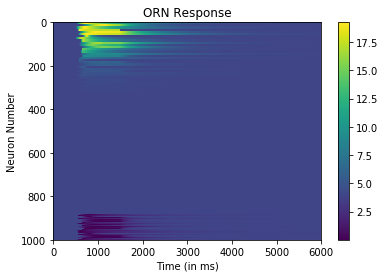

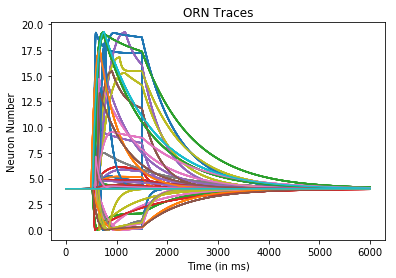

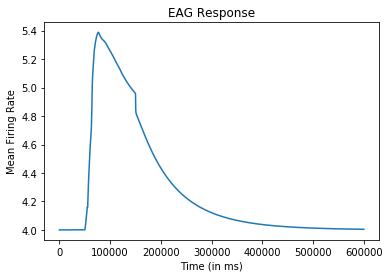

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import polarTools as pt
import easygui
import pickle
%matplotlib inline

# Select the Odorant, Odor Delivery Protocol, Locust Model
odor_path = easygui.fileopenbox(msg='Open Odor File',title='Odor Browser',default='/home/iiser/Collins-Saptarshi 2019b/DAMN/A. Odors/*.odor',filetypes=['*.odor'])
protocol_path = easygui.fileopenbox(msg='Open Protocol File',title='Odor Protocol Browser',default='/home/iiser/Collins-Saptarshi 2019b/DAMN/A. Odor Protocols/*.protocol',filetypes=['*.protocol'])
locust_path = easygui.fileopenbox(msg='Open Locust File',title='Locust Browser',default='/home/iiser/Collins-Saptarshi 2019b/DAMN/A. Locusts/*.locust',filetypes=['*.locust'])

# Load the Odorant, Odor Delivery Protocol, Locust Model
with open(odor_path, 'rb') as fp:
    odor = pickle.load(fp)
with open(protocol_path, 'rb') as fp:
    protocol = pickle.load(fp)
with open(locust_path, 'rb') as fp:
    locust = pickle.load(fp)

# Define ORN Response Generator
def generate_orn(orn_number,duration,resolution,odorVec,odorStart,odorEnd): # Function to generate single ORN Trace
    
    baseline = 0.2#locust['baseline_firing']/locust['peak_firing'] # Baseline Firing Rate Ratio
    trace = baseline*np.ones(int(duration/resolution)) # Set Baseline activity for the Protocol Duration
    rec_field = pt.generateUniform(1,odor['dim_odorspace'],seed=int(locust['rec_seeds'][orn_number])) # Receptive Field of ORNs in Odor Space
    
    latency = locust['latency'][orn_number] # Latency of Response to Odor Presentation
    t_rise = locust['t_rise'][orn_number] # Time to Rise to Peak
    t_fall = locust['t_fall'][orn_number] # Response Decay Time
    tuning = locust['tuning'][orn_number] # Odor Tuning-width / Sensitivity
    
    def sigmoid(x,a1=locust['a1'],a2=locust['a2']):	# Sigmoid for Response
        return 1/(1+np.exp(-a1*(x-a2)))
    
    odorMag = np.linalg.norm(odorVec) # Odor Concentration
    cosSim = np.dot(odorVec,rec_field)/(np.linalg.norm(odorVec)*np.linalg.norm(rec_field)) # Cosine Similarity wrt Odor

    if np.arccos(cosSim) < np.deg2rad(locust['inh_threshold']):	# Minimum Response Threshhold
        res_strength = (1-baseline)*sigmoid(odorMag*np.cos(np.arccos(cosSim)/2)**tuning)
    else:
        res_strength = -baseline
    
    if locust['f_sharp'][orn_number]:
        # Generate Sharp Trace
        rise = np.arange(0,t_rise/2,resolution)
        rise = baseline+res_strength*2*np.exp(1)/t_rise*rise*np.exp(-2*rise/t_rise)
        riseStartIndex = int((odorStart+latency)/resolution)
        riseEndIndex = riseStartIndex+rise.shape[0]
        trace[riseStartIndex:riseEndIndex] = rise
        peak = rise[-1]
        fall = np.linspace(0,duration-riseEndIndex*resolution,trace.shape[0]-riseEndIndex)
        fall = (peak-baseline)*np.exp(-fall/t_fall)+baseline
        fallStartIndex = riseEndIndex
        trace[fallStartIndex:] = fall    
    else:
        # Generate Broad Trace
        rise = np.arange(0,t_rise,resolution)
        rise = baseline+res_strength*np.exp(1)/t_rise*rise*np.exp(-rise/t_rise)
        riseStartIndex = int((odorStart+latency)/resolution)
        riseEndIndex = int((odorStart+latency)/resolution)+rise.shape[0]
        trace[riseStartIndex:riseEndIndex] = rise
        peak_1 = rise[-1]
        adaptation_rate = locust['adaptation_extent'][orn_number] # Amplitude of Adaptation-related Decay
        t_adaptation = locust['t_adaptation'][orn_number] # Odor Adaptation Time
        adaptation = np.arange(0,(int(odorEnd/resolution)-riseEndIndex)*resolution,resolution)
        adaptation = (peak_1-(adaptation_rate*res_strength+baseline))*np.exp(-adaptation/t_adaptation)+(adaptation_rate*res_strength+baseline)
        adaptationStartIndex = riseEndIndex
        adaptationEndIndex = adaptationStartIndex+adaptation.shape[0]
        trace[adaptationStartIndex:adaptationEndIndex] = adaptation
        peak_2 = adaptation[-1]
        fall = np.arange(0,(trace.shape[0]-adaptationEndIndex)*resolution,resolution)
        fall = (peak_2-baseline)*np.exp(-fall/t_fall) + baseline
        fallStartIndex = adaptationEndIndex
        trace[fallStartIndex:] = fall
    
    trace = trace*locust['peak_firing'] # Scale to Peak Firing Rate
    
    return trace

# Generate Odor Response

print("Generating ORN Responses...")

orns = []
for i in range(locust['ORN_types']): # Generate ORN types
    orns.append(generate_orn(i,protocol['duration'],protocol['resolution'],odor['odor_vector'],protocol['odor_start'],protocol['odor_start']+protocol['odor_duration']))
    print('{}/{} ORN Types Completed'.format(i+1,locust['ORN_types']), end = '\r')

orns = np.array(orns*locust['ORN_replicates'])

print("Generation Complete. Plotting.")

# Plot the ORN Response
plt.figure()
order = np.argsort(orns.max(axis=1))
plt.imshow(orns[order[::-1],::100], aspect='auto')
plt.colorbar()
plt.xlabel('Time (in ms)')
plt.ylabel('Neuron Number')
plt.title('ORN Response')
plt.savefig('ORN Response.png')

# Plot the ORN Traces
plt.figure()
order = np.argsort(orns.mean(axis=1))
plt.plot(orns[:,::100].T)
plt.xlabel('Time (in ms)')
plt.ylabel('Neuron Number')
plt.title('ORN Traces')
plt.savefig('ORN Traces.png')

# Plot EAD
plt.figure()
plt.plot(orns.mean(axis=0))
plt.xlabel('Time (in ms)')
plt.ylabel('Mean Firing Rate')
plt.title('EAG Response')
plt.savefig('EAG Response.png')

# Save ORN Data
np.save('ORN Firing Data',orns[:,::100])


Generating Antennal Input...
Generation Complete
'Information has been transferred to the Antennal Lobe. Thank you for using our services.' - ORNs


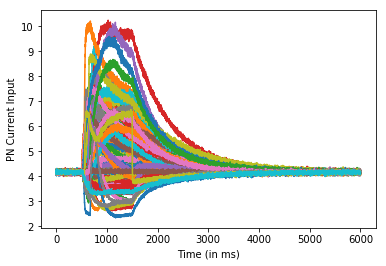

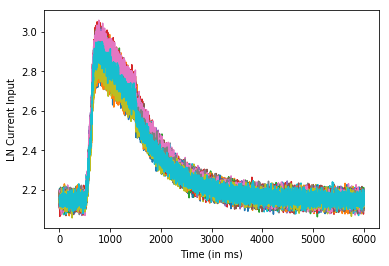

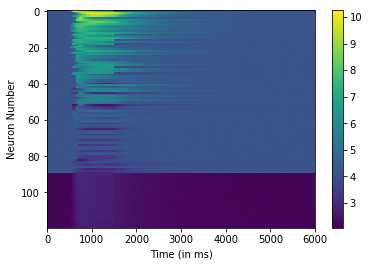

In [75]:

print("Generating Antennal Input...")

# Generate Antennal Output
ORN_Output = np.matmul(orns.T,locust['ORN-AL']).T

p_n = int(0.75*locust['AL_n'])

# PN_scale = locust['max_pn_current']/ORN_Output[:p_n,:].max() # PN Scaling Factor
# LN_scale = locust['max_ln_current']/ORN_Output[p_n:,:].max() # LN Scaling Factor

PN_scale = 10/ORN_Output[:p_n,:].max() # PN Scaling Factor
LN_scale = 3/ORN_Output[p_n:,:].max() # LN Scaling Factor

# Scale ORN Output to AL Input
ORN_Output[:90,:] = (ORN_Output[:p_n,:] * PN_scale)
ORN_Output[90:,:] = (ORN_Output[p_n:,:] * LN_scale)

ORN_Output = ORN_Output + ORN_Output*locust['random_noise_level']*np.random.normal(size=ORN_Output.shape)

print("Generation Complete")

# Plot PN Current 
plt.figure()
plt.plot(ORN_Output[:p_n,::100].T)
plt.xlabel('Time (in ms)')
plt.ylabel('PN Current Input')
plt.savefig('PN Current.png')

# Plot LN Current 
plt.figure()
plt.plot(ORN_Output[p_n:,::100].T)
plt.xlabel('Time (in ms)')
plt.ylabel('LN Current Input')
plt.savefig('LN Current.png')

# Plot Overall Current
plt.figure()
order = np.concatenate((np.argsort(ORN_Output[:p_n,:].max(axis=1))[::-1],p_n+np.argsort(ORN_Output[p_n:,:].max(axis=1))[::-1]))
plt.imshow(ORN_Output[order,::100], aspect='auto')
plt.colorbar()
plt.xlabel('Time (in ms)')
plt.ylabel('Neuron Number')
plt.savefig('AL Input Current.png')

# Save Current Input
np.save('current_input',ORN_Output)

print("'Information has been transferred to the Antennal Lobe. Thank you for using our services.' - ORNs")

In [44]:
def spike_generator(trace,resolution):
    fr = trace*resolution/1000
    p = fr/np.exp(fr)
    spike = np.random.uniform(size=p.shape)<p
    return np.int64(spike)

In [45]:
orns_spike = np.zeros(orns.shape)
for i in range(orns.shape[0]):
    orns_spike[i,:] = spike_generator(orns[i,:],0.01)
    print('{}/{} ORN Spiking Completed'.format(i+1,locust['ORN_types']*locust['ORN_replicates']), end = '\r')

In [246]:
# p_n = int(0.75*locust['AL_n'])
# l_n = int(0.25*locust['AL_n'])
# rows = 10
# col_len = orns.shape[1]
# for j in range(int(p_n/rows)):
#     for i in range(rows):
#         plt.plot(np.linspace(j,j+0.95,col_len),i+ orns[i,:]/20)   
#         plt.plot(np.linspace(j,j+0.95,col_len),i+ orns_spike[i,:]/2)

In [53]:
print("Generating Antennal Input...")

# Generate Antennal Output
ORN_Output = np.matmul(orns.T,locust['ORN-AL']).T
ORN_Output_s = np.matmul(orns_spike.T,locust['ORN-AL']).T

p_n = int(0.75*locust['AL_n'])

ORN_Output_current = np.zeros(ORN_Output_s.shape)
for i in range(ORN_Output_s.shape[0]):
    if i<p_n:
        cfilter = np.linspace(1,0,250)
    else:
        cfilter = np.linspace(1,0,250)
    ORN_Output_current[i,:] = np.convolve(ORN_Output_s[i,:], cfilter,'same')
    print('{}/{} Synaptic Integration Completed'.format(i+1,locust['AL_n']), end = '\r')

Generating Antennal Input...


In [49]:
# def minmax(trace):
#     return (trace)/ORN_Output.max()

p_n = int(0.75*locust['AL_n'])
order = np.concatenate((np.argsort(ORN_Output[:p_n,:].max(axis=1))[::-1],p_n+np.argsort(ORN_Output[p_n:,:].max(axis=1))[::-1]))

# plt.figure(figsize=(9,9))
# for n,i in enumerate(order[:10]):
#     plt.plot(n+ORN_Output_s[i,:]/3,alpha=0.7)
#     plt.plot(n+minmax(ORN_Output[i,:]))

In [58]:
def minmax(trace):
    return (trace)/(trace.max())

test_trace = ORN_Output_s[order[0],:]
cfilter = np.linspace(1.5,0,2500)
plt.plot(minmax(np.convolve(test_trace, cfilter,'same')),alpha=0.7)
plt.plot(minmax(ORN_Output[order[0],:]))

In [5]:
from sklearn.decomposition import PCA

In [8]:
model = PCA(n_components=3)
#ORN_Output = ORN_Output + ORN_Output*locust['random_noise_level']*np.random.normal(size=ORN_Output.shape)*2
PC = model.fit_transform(ORN_Output_current[:p_n,:].T)
%matplotlib qt4

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(PC[::100,0],PC[::100,1],PC[::100,2],c=range(int(PC.shape[0]/100)),alpha=0.05)
ax.scatter(PC[50000:450000:1000,0],PC[50000:450000:1000,1],PC[50000:450000:1000,2],c='r')
ax.plot(PC[::100,0],PC[::100,1],PC[::100,2])

In [10]:
#ORN_Output_2 = ORN_Output + ORN_Output*0.2*np.random.normal(size=ORN_Output.shape)
temp = np.array(np.hsplit(ORN_Output_current[:p_n,:],ORN_Output_current.shape[1]/1000)).mean(axis=2)

model = PCA(n_components=3)
PC = model.fit_transform(temp)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(PC[:,0],PC[:,1],PC[:,2],c=range(PC.shape[0]))
ax.scatter(PC[50000:450000,0],PC[50000:450000,1],PC[50000:450000,2],c='r')
ax.plot(PC[:,0],PC[:,1],PC[:,2])

In [241]:
plt.imshow(ORN_Output_current[:p_n,::100],aspect='auto')

In [47]:
plt.hist(np.diff(np.arange(ORN_Output_s[0,50000:450000].shape[0])[ORN_Output_s[0,50000:450000]>0])/100,bins=30,)
plt.hist(np.diff(np.arange(ORN_Output_s[0,:50000].shape[0])[ORN_Output_s[0,:50000]>0])/100,bins=30)

(array([13., 14.,  8., 11., 13.,  5.,  7.,  1.,  4.,  3.,  2.,  1.,  2.,
         2.,  0.,  2.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  1.,  1.]),
 array([2.0000e-02, 9.3200e-01, 1.8440e+00, 2.7560e+00, 3.6680e+00,
        4.5800e+00, 5.4920e+00, 6.4040e+00, 7.3160e+00, 8.2280e+00,
        9.1400e+00, 1.0052e+01, 1.0964e+01, 1.1876e+01, 1.2788e+01,
        1.3700e+01, 1.4612e+01, 1.5524e+01, 1.6436e+01, 1.7348e+01,
        1.8260e+01, 1.9172e+01, 2.0084e+01, 2.0996e+01, 2.1908e+01,
        2.2820e+01, 2.3732e+01, 2.4644e+01, 2.5556e+01, 2.6468e+01,
        2.7380e+01]),
 <a list of 30 Patch objects>)

In [35]:
ORN_Output_s[0,50000:450000]

array([0., 0., 0., ..., 0., 0., 0.])